In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

In [2]:
from pyimcom.config import Config, Settings as Stn
from pyimcom.coadd import Block
from pyimcom.analysis import OutImage, Mosaic
from concurrent.futures import ProcessPoolExecutor

In [3]:
from metadetect_driver import parse_driver_cfg, MetaDetectRunner

# Example Uses

#### We will run some examples of running this metadetect Driver using a 2x2 block mosaic produced by PyIMCOM

## Single Band

In [4]:
with open('../config/metadetect_default.yaml', 'r') as file:
    METADETECT_CONFIG= yaml.safe_load(file)
with open('../config/driver_default.yaml', 'r') as file:
    DEFAULT_DRIVER_CFG= yaml.safe_load(file)

### Quick explanation of the configuration files read above

1. `METADETECT_CONFIG`: This is the configuration file that goes into Metadetect. For general info about how metadetect works, see the metadetect tutorial: https://github.com/Roman-HLIS-Cosmology-PIT/tutorial-metadetect/tree/main
2. `DEFAULT_DRIVER_CFG`: This is the configuration file for the driver we have made here. The arguments are the following:
 
    - `psf_img_size`: Size of the PSF image to make. The PSF is made inside the driver from the PyIMCOM configuration.
    - `bound_size`: Sets the maximum number of pixels from the edge for which we mask objects. Example, if bound_size = 100, all detections                   that are 100 pixels from the edge of the image are discarded from the catalog.
    - `mdet_seed`: Random seed that goes into Metadetect
    - `keepcols`: What columns from the Metadetect outputs to keep. Given as a list
    - `det_bands`: What bands to use for detection. The default is to use all bands given.
    - `shear_bands`: What bands to use for shape measurement. The default is to use all bands given.
    - `layer`: What layer from the coadds to use (as a string). The default is the science layer ('SCI')
    - `max_workers`: Maximum number of workers for parallelization of multiple block. Driver code allows to parallelize if multiple blocks                     need to be processed. See https://docs.python.org/3/library/concurrent.futures.html for more details.
    - `chunksize`: Chunksize for the parallelization. See https://docs.python.org/3/library/concurrent.futures.html for more details.
    - `outdir`: The output directory to ave catalogs if you want them saved. 

In [5]:
# Read the config file from which the Mosaic was made
cfg = Config(cfg_file = '../IMCOM_data/configs/config_prod_H.json')

In [6]:
# The actual data was run somewhere else, so we have to change the config file directory where the images live
cfg.outstem = '../IMCOM_data/images/H158/output'

In [7]:
# Get the full Mosaic from PyIMCOM interface (no images are actually loaded when doing this)
mosaic = Mosaic(cfg)

### Single Block

In [8]:
# select a single block in the mosaic
blk = mosaic.outimages[0][1]

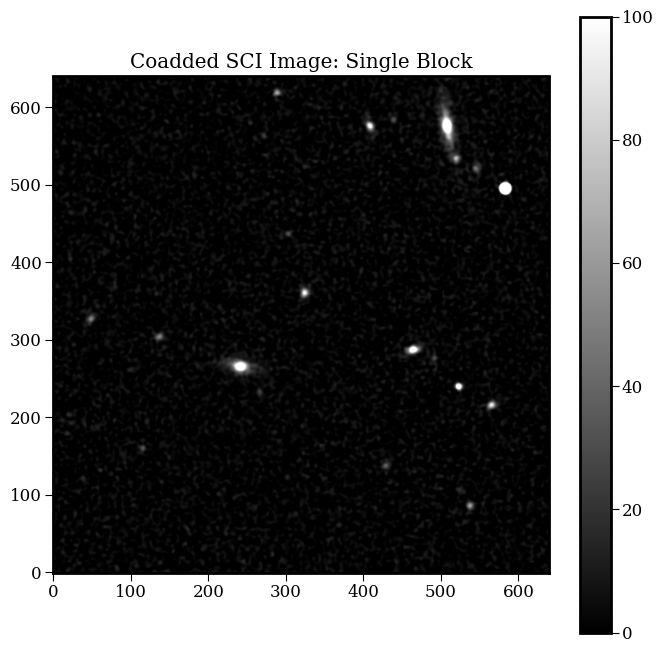

In [9]:
# Visualize Block
img = blk.get_coadded_layer('SCI')
# Plot the image
plt.figure(figsize=(8, 8))
plt.imshow(img , cmap='gray', origin='lower',vmin = 0,  vmax = 100)
#plt.ylim(0,600)
#plt.xlim(30,100)
plt.colorbar()  
plt.title("Coadded SCI Image: Single Block")
plt.show()

In [10]:
# Initialize object with block
mdet_runner = MetaDetectRunner(blk, meta_cfg = METADETECT_CONFIG, driver_cfg = DEFAULT_DRIVER_CFG)

#### Saving outputs to disk:

If you want to save the combined final catalog of all processed blocks to disk, set `save = True`. By default its set to `False`. If you want to save each individual catalog from each block to disk, set `save_blocks = True`. By default its set to `False`. If this is set to true, the blocks are saved to a subdirectory in the output directory of the `DEFAULT_DRIVER_CFG`, and there they are organized by row number (similar to how the PyIMCOM coadds are stored per block). 

In [12]:
# Run the metadetect driver on a single
res = mdet_runner.make_catalog(save = False, save_blocks = False)

In [13]:
res

,ra_meta,dec_meta,pgauss_flags,pgauss_s2n,pgauss_H158_band_flux,pgauss_H158_band_flux_flags,pgauss_T,pgauss_psf_T
0,9.544516,-44.004763,0,5.298731,0.276392,0.0,0.037102,0.022301
1,9.543098,-44.003654,8,12.960835,0.676062,0.0,-0.000505,0.022301
2,9.547341,-44.003374,0,61.203373,3.192485,0.0,0.121085,0.022301
3,9.543984,-44.003141,0,22.919909,1.195546,0.0,0.029722,0.022301
4,9.548916,-44.002960,0,6.966231,0.363372,0.0,0.033642,0.022301
5,9.546090,-44.002344,0,13.930927,0.726664,0.0,0.030155,0.022301
6,9.543152,-44.000467,0,11.202093,0.584323,0.0,0.042928,0.022301


This may seem like few objects, but in the default settings we are removing all objects 100 pixels from the edge. You can change this by changing `bound_size` in the driver config.

### Mosaic

In [14]:
# Initialize object with mosaic
mdet_runner = MetaDetectRunner(mosaic, meta_cfg = METADETECT_CONFIG, driver_cfg = DEFAULT_DRIVER_CFG)

In [15]:
# Run the metadetect driver on a mosaic (by default runs all blocks in mosaic)
res = mdet_runner.make_catalog(save = False, save_blocks = False)

In [16]:
res

,ra_meta,dec_meta,pgauss_flags,pgauss_s2n,pgauss_H158_band_flux,pgauss_H158_band_flux_flags,pgauss_T,pgauss_psf_T
0,9.552521,-44.004747,0,166.543921,8.617699,0.0,0.001372,0.022301
1,9.557143,-44.003853,0,8.506048,0.440140,0.0,0.014895,0.022301
2,9.556495,-44.003161,0,7.229583,0.374090,0.0,0.023904,0.022301
3,9.555172,-44.002416,0,19.868738,1.028094,0.0,0.039308,0.022301
4,9.552035,-44.001591,0,27.899781,1.443655,0.0,0.027120,0.022301
5,9.555229,-43.998075,0,1171.876588,60.503801,0.0,0.000178,0.022301
6,9.554159,-43.997190,0,232.955640,12.027463,0.0,0.377259,0.022301
7,9.551942,-43.996315,0,5.804951,0.299709,0.0,0.037529,0.022301
8,9.552179,-43.995883,0,6.185608,0.319362,0.0,0.025081,0.022301
9,9.553899,-43.994917,0,9.373031,0.483928,0.0,0.033742,0.022301


#### You can also run individual blocks within a mosaic

To do this there are two options:
1. Pass arguments `block_rows` and `block_cols`, representing the blocks you want to run. For example passing `block_rows = 1, block_cols = 0`, means only this particular Block in the Mosaic will be processed. Alternatively you can pass a list for each one: `block_rows = [1, 0], block_cols = [0,1]`, which will run those two blocks only.
2. Pass argument `block_ids`, representing a single number ID in the Mosaic. If a Mosaic has 8 blocks on each side (nblocks = 8, 8x8 = 64 total blocks), then there is a number ID for each block. Since the indexing starts at zero, `block_ids` should be an integer (or list of integers) between [0 , nblocks^2 -1].

Only one of these two options should be passed.

In [17]:
# This only runs on block 0_1 inside the Mosaic (in PyIMCOM convention the row is the 2nd digit and column the first)
res = mdet_runner.make_catalog(block_rows = 1, block_cols = 0, save = False, save_blocks = False)

In [18]:
# This only runs on block 0_1 inside the Mosaic (in PyIMCOM convention the row is the 2nd digit and column the first)
res = mdet_runner.make_catalog(block_ids = 1, save = False, save_blocks = False)

#### Or for entire rows (or columns) in a Mosaic:
By specifying only one of block_rows and block_cols, it runs detection on all blocks in the specified rows/cols.
So for example setting block_rows = [1,2] runs detection on all blocks in rows 1 and 2. Similarly for block_cols.

In [19]:
# This only runs on block 0_1 inside the Mosaic (in PyIMCOM convention the row is the 2nd digit and column the first)
res = mdet_runner.make_catalog(block_rows = [1],save = False, save_blocks = False)

## Multi-band

In [20]:
# Read the config file for both bands
cfg_H = Config(cfg_file = '../IMCOM_data/configs/config_prod_H.json')
cfg_J = Config(cfg_file = '../IMCOM_data/configs/config_prod_J.json')

In [21]:
cfg_H.outstem = '../IMCOM_data/images/H158/output'
cfg_J.outstem = '../IMCOM_data/images/J129/output'

In [22]:
mosaic_H = Mosaic(cfg_H)
mosaic_J= Mosaic(cfg_J)
mosaics = [mosaic_H, mosaic_J]

### Single Block

In [23]:
# select a single block in the mosaic
blks = [mosaic.outimages[0][1] for mosaic in mosaics]

In [24]:
# Initialize object with block
mdet_runner = MetaDetectRunner(blks, meta_cfg = METADETECT_CONFIG, driver_cfg = DEFAULT_DRIVER_CFG)

In [25]:
# Run the metadetect driver on a single
res = mdet_runner.make_catalog(save = False, save_blocks = False)

In [26]:
res

,ra_meta,dec_meta,pgauss_flags,pgauss_s2n,pgauss_H158_band_flux,pgauss_J129_band_flux,pgauss_H158_band_flux_flags,pgauss_J129_band_flux_flags,pgauss_T,pgauss_psf_T
0,9.544514,-44.004758,0,6.385230,0.277595,0.200041,0.0,0.0,0.030100,0.021308
1,9.549246,-44.004514,0,4.702714,0.203486,0.148377,0.0,0.0,0.035971,0.021302
2,9.543100,-44.003656,0,17.723087,0.680085,0.653657,0.0,0.0,0.004975,0.021170
3,9.547340,-44.003376,0,70.373367,3.196251,2.055813,0.0,0.0,0.127736,0.021360
4,9.543577,-44.003253,0,5.395623,0.221408,0.183367,0.0,0.0,0.030795,0.021242
5,9.543985,-44.003142,0,35.772856,1.457085,1.227521,0.0,0.0,0.091390,0.021234
6,9.548913,-44.002959,0,9.802501,0.363423,0.375384,0.0,0.0,0.037225,0.021135
7,9.546086,-44.002345,0,19.623419,0.727840,0.751136,0.0,0.0,0.037073,0.021135
8,9.546403,-44.001522,0,4.563851,0.144033,0.202168,0.0,0.0,0.025857,0.020986
9,9.543160,-44.000464,0,14.347443,0.591274,0.484835,0.0,0.0,0.043431,0.021247


You may have noticed we have more objects detected. This is because Metadetect creates a multi-band coadd for detection, so we can find more objects!

### Mosaic

In [27]:
# Initialize object with mosaic
mdet_runner = MetaDetectRunner(mosaics, meta_cfg = METADETECT_CONFIG, driver_cfg = DEFAULT_DRIVER_CFG)

In [28]:
# Run the metadetect driver on a mosaic (by default runs all blocks in mosaic)
res = mdet_runner.make_catalog(save = False, save_blocks = False)

In [29]:
res

,ra_meta,dec_meta,pgauss_flags,pgauss_s2n,pgauss_H158_band_flux,pgauss_J129_band_flux,pgauss_H158_band_flux_flags,pgauss_J129_band_flux_flags,pgauss_T,pgauss_psf_T
0,9.552522,-44.004747,0,231.036122,8.618087,7.948433,0.0,0.0,0.002335,0.021107
1,9.557140,-44.003849,0,11.582400,0.439797,0.391366,0.0,0.0,0.019426,0.021124
2,9.556500,-44.003162,0,10.846593,0.376198,0.399204,0.0,0.0,0.041298,0.021038
3,9.555173,-44.002416,0,31.595415,1.224137,1.045203,0.0,0.0,0.079109,0.021144
4,9.552035,-44.001592,0,42.327876,1.579766,1.455439,0.0,0.0,0.062273,0.021107
5,9.555229,-43.998075,0,1787.252190,60.507909,68.131713,0.0,0.0,0.000469,0.021027
6,9.551082,-43.997525,0,6.025918,0.238993,0.196465,0.0,0.0,0.061518,0.021180
7,9.554159,-43.997191,0,320.515224,12.027652,11.100174,0.0,0.0,0.368659,0.021124
8,9.552436,-43.996730,0,5.755212,0.264185,0.153493,0.0,0.0,0.042126,0.021345
9,9.551945,-43.996314,0,8.067805,0.298050,0.283876,0.0,0.0,0.034241,0.021108
